In [0]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg- dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Unable to locate package libjpeg
E: Unable to locate package dev
E: Package 'libav-tools' has no installation candidate


In [0]:
!pip install pyvirtualdisplay
!pip install piglet

  Running setup.py bdist_wheel for pyvirtualdisplay ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/d1/8c/16/1c64227974ae29c687e4cc30fd691d5c0fd40f54446dde99da
  Running setup.py bdist_wheel for EasyProcess ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/b4/c6/e3/c163b04029d8fccfd54b809802640c1af587a01be8d7a04e1a
Successfully built pyvirtualdisplay EasyProcess
    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 92kB 4.5MB/s 
  Running setup.py bdist_wheel for piglet ... - \ done
  Stored in directory: /root/.cache/pip/wheels/c7/59/a5/5bd1a35a4a4596714c4c7925a1751e7b1580b6ced363fd7969
Successfully built piglet


In [0]:
!pip install gym
!pip install "gym[box2d]"

    100% |████████████████████████████████| 1.5MB 7.8MB/s 
    100% |████████████████████████████████| 1.0MB 12.6MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
Successfully built gym
    100% |████████████████████████████████| 450kB 5.9MB/s 


In [0]:
import tensorflow as tf
import gym

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

import random

from collections import deque

In [0]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])


class Memory(object):  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.0001
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [0]:
class IQNAgent:
    def __init__(self, sess, a_dim, s_dim,
                 num_tau=32,
                 num_tau_prime=8,
                 learning_rate=1e-3,
                 gamma=0.99,
                 batch_size=32,
                 buffer_size=10000,
                 target_update_step=100,
                 e_greedy=True,
                 e_step=5000,
                 eps_max=0.9,
                 eps_min=0.01,
                 eta=0.1,
                 gradient_norm=None
                 ):
        self.memory = Memory(buffer_size)
        self.iter = 0
        self.sess = sess
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.buffer_size = buffer_size
        self.num_tau = num_tau
        self.num_tau_prime = num_tau_prime
        self.e_greedy = e_greedy
        self.e_step = e_step
        self.eps_max = eps_max
        self.eps_min = eps_min
        self.eps = 0.0 if not e_greedy else self.eps_max
        self.target_update_step = target_update_step
        self.gradient_norm = gradient_norm
        self.eta = eta

        self.a_dim, self.s_dim = a_dim, s_dim
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.A = tf.placeholder(tf.float32, [None, 1], 'a')
        self.A_ = tf.placeholder(tf.float32, [None, 1], 'a')
        self.T = tf.placeholder(tf.float32, [None, None], 'theta_t')
        self.tau = tf.placeholder(tf.float32, [None, None], 'tau')
        self.tau_ = tf.placeholder(tf.float32, [None, None], 'tau_')
        self.ISWeights = tf.placeholder(tf.float32, [None, 1], name='IS_weights')

        self.q_theta_eval_train, self.q_mean_eval_train, self.q_theta_eval_test, self.q_mean_eval_test = self._build_net(
            self.S, self.tau,
            scope='eval_params',
            trainable=True)
        self.q_theta_next_train, self.q_mean_next_train, _, _ = self._build_net(self.S_, self.tau_,
                                                                                scope='target_params',
                                                                                trainable=False)

        self.qe_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_params')
        self.qt_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_params')

        self.hard_replace = [[tf.assign(qt, qe)]
                             for qt, qe in zip(self.qt_params, self.qe_params)]

        a_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), tf.squeeze(tf.to_int32(self.A))], axis=1)
        self.q_theta_eval_a = tf.gather_nd(params=self.q_theta_eval_train, indices=a_indices)
        a_next_max_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32),
                                       tf.squeeze(tf.to_int32(self.A_))], axis=1)
        self.q_theta_next_a = tf.gather_nd(params=self.q_theta_next_train, indices=a_next_max_indices)

        self.loss, self.qr_error = self.quantile_huber_loss()

        if self.gradient_norm is not None:
            q_optimizer = tf.train.AdamOptimizer(self.learning_rate, epsilon=0.01 / self.batch_size)
            q_gradients = q_optimizer.compute_gradients(self.loss, var_list=self.qe_params)
            for i, (grad, var) in enumerate(q_gradients):
                if grad is not None:
                    q_gradients[i] = (tf.clip_by_norm(grad, self.gradient_norm), var)
            self.train_op = q_optimizer.apply_gradients(q_gradients)
        else:
            self.train_op = tf.train.AdamOptimizer(self.learning_rate, epsilon=0.01 / self.batch_size).minimize(
                self.loss, var_list=self.qe_params)

        self.saver = tf.train.Saver()
        
        self.sess.run(tf.global_variables_initializer())

    def _build_net(self, s, tau, scope, trainable):
      
      with tf.device('/gpu:0'):

        s_tiled = tf.tile(s, [1, tf.shape(tau)[1]])
        
        s_reshaped = tf.reshape(s_tiled, [-1, self.s_dim])
        tau_reshaped = tf.reshape(tau, [-1, 1])

        with tf.variable_scope(scope):
            init_w = tf.contrib.layers.xavier_initializer()
            init_b = tf.constant_initializer(0.001)
            pi_mtx = tf.constant(np.expand_dims(np.pi * np.arange(0, 64), axis=0), dtype=tf.float32)
            
            cos_tau = tf.cos(tf.matmul(tau_reshaped, pi_mtx))
            
            net_phi = tf.layers.dense(cos_tau, self.s_dim, activation=tf.nn.relu,
                                      kernel_initializer=init_w, bias_initializer=init_b, name='phi',
                                      trainable=trainable)
            
            net_psi = s_reshaped

            joint_term = net_psi + tf.multiply(net_psi, net_phi)
            
            q_net1 = tf.layers.dense(joint_term, 512, activation=tf.nn.selu,
                                      kernel_initializer=init_w, bias_initializer=init_b, name='l1',
                                      trainable=trainable)
            
            q_net2 = tf.layers.dense(q_net1, 512, activation=tf.nn.selu,
                                      kernel_initializer=init_w, bias_initializer=init_b, name='l2',
                                      trainable=trainable)
            
            q_flat = tf.layers.dense(q_net2, self.a_dim, activation=None,
                                      kernel_initializer=init_w, bias_initializer=init_b, name='l3',
                                      trainable=trainable)
            
            q_re_train = tf.transpose(tf.split(q_flat, self.batch_size, axis=0), perm=[0, 2, 1])

            q_re_test = tf.transpose(tf.split(q_flat, 1, axis=0), perm=[0, 2, 1])

            q_mean_train = tf.reduce_mean(q_re_train, axis=2)

            q_mean_test = tf.reduce_mean(q_re_test, axis=2)

        return q_re_train, q_mean_train, q_re_test, q_mean_test

    def update_target_net(self):
        self.sess.run(self.hard_replace)

    def quantile_huber_loss(self):
        
        q_theta_expand = tf.tile(tf.expand_dims(self.q_theta_eval_a, axis=2), [1, 1, self.num_tau_prime])
        T_theta_expand = tf.tile(tf.expand_dims(self.T, axis=1), [1, self.num_tau_prime, 1])

        u_theta = T_theta_expand - q_theta_expand

        rho_u_tau = self._rho_tau(u_theta, tf.tile(tf.expand_dims(self.tau, axis=2), [1, 1, self.num_tau_prime]))

        qr_error = tf.reduce_sum(tf.reduce_mean(rho_u_tau, axis=2), axis=1)

        qr_loss = tf.reduce_sum(self.ISWeights * qr_error)

        return qr_loss, qr_error

    def memory_add(self, s, a, r, s_, d):
      
      with tf.device('/gpu:0'):

        tau = np.random.rand(self.batch_size, self.num_tau_prime)
        tau_ = np.random.rand(self.batch_size, self.num_tau_prime)
        tau_beta_ = self.conditional_value_at_risk(self.eta, np.random.rand(self.batch_size, self.num_tau))

        T_mean_K = self.sess.run(self.q_mean_next_train, feed_dict={self.S_: np.repeat(s_[np.newaxis, :],
                                                                                     self.batch_size,
                                                                                     0),
                                                                    self.tau_: tau_beta_})
        ba_ = np.expand_dims(np.argmax(T_mean_K, axis=1), axis=1)

        T_theta_ = self.sess.run(self.q_theta_next_a, feed_dict={self.S_: np.repeat(s_[np.newaxis, :],
                                                                                     self.batch_size,
                                                                                     0),
                                                                 self.A_: ba_,
                                                                 self.tau_: tau_})
        

        T_theta = np.repeat(np.copy(r)[np.newaxis, :], self.batch_size, 0) + (1 - np.repeat(np.copy(d)[np.newaxis, :], self.batch_size, 0)) * self.gamma * T_theta_
        T_theta = T_theta.astype(np.float32)

        error = self.sess.run(self.qr_error, feed_dict={self.S: np.repeat(s[np.newaxis, :], self.batch_size, 0),
                                                        self.A: np.repeat(np.copy(a)[np.newaxis, :], self.batch_size,
                                                                          0),
                                                        self.T: T_theta,
                                                        self.tau: tau})

        self.memory.add(error[0], (s, a, r, s_, d))

    def learn(self):
      
      if self.iter % self.target_update_step == 0:
          self.update_target_net()
      
      with tf.device('/gpu:0'):
        
        minibatch, idxs, IS_weight = self.memory.sample(self.batch_size)
        minibatch = np.array(minibatch)
        bs = np.vstack(minibatch[:, 0])
        ba = np.vstack(minibatch[:, 1])
        br = np.vstack(minibatch[:, 2])
        bs_ = np.vstack(minibatch[:, 3])
        bd = np.vstack(minibatch[:, 4])
        IS_weight = IS_weight[:, np.newaxis]

        tau = np.random.rand(self.batch_size, self.num_tau_prime)
        tau_ = np.random.rand(self.batch_size, self.num_tau_prime)
        tau_beta_ = self.conditional_value_at_risk(self.eta, np.random.rand(self.batch_size, self.num_tau))

        T_mean_K = self.sess.run(self.q_mean_next_train, feed_dict={self.S_: bs_, self.tau_: tau_beta_})
        ba_ = np.expand_dims(np.argmax(T_mean_K, axis=1), axis=1)

        T_theta_ = self.sess.run(self.q_theta_next_a, feed_dict={self.S_: bs_, self.A_: ba_, self.tau_: tau_})

        T_theta = br + (1 - bd) * self.gamma * T_theta_
        T_theta = T_theta.astype(np.float32)

        loss, qr_error, _ = self.sess.run([self.loss, self.qr_error, self.train_op], {self.S: bs,
                                                                                      self.A: ba,
                                                                                      self.T: T_theta,
                                                                                      self.tau: tau,
                                                                                      self.ISWeights: IS_weight})

        for i in range(self.batch_size):
            idx = idxs[i]
            self.memory.update(idx, qr_error[i])

        self.iter += 1

        if self.eps > self.eps_min:
            self.eps -= self.eps_max / self.e_step

        return loss

    @staticmethod
    def conditional_value_at_risk(eta, tau):
        return eta * tau

    @staticmethod
    def _rho_tau(u, tau, kappa=1):
        delta = tf.cast(u < 0, 'float')
        if kappa == 0:
            return (tau - delta) * u
        else:
            return tf.abs(tau - delta) * tf.where(tf.abs(u) <= kappa, 0.5 * tf.square(u),
                                                  kappa * (tf.abs(u) - kappa / 2))

    def choose_action(self, state):
        state = state[np.newaxis, :]
        tau_K = np.random.rand(1, self.num_tau)
        tau_beta = self.conditional_value_at_risk(self.eta, tau_K)
        
        if np.random.uniform() > self.eps:
          actions_value = self.sess.run(self.q_mean_eval_test, feed_dict={self.S: state, self.tau: tau_beta})
          action = np.argmax(actions_value)
        
        else:
          action = np.random.randint(0, self.a_dim)

        return action

In [0]:
MINIBATCH_SIZE = 256
TRAIN_START = 1500
TARGET_UPDATE = 10
MEMORY_SIZE = 50000
LEARNING_RATE = 0.0001
DISCOUNT = 0.99

RENDER = False
ENV_NAME = 'LunarLander-v2'

In [0]:
env = gym.make(ENV_NAME)
env.seed(1234)

np.random.seed(1234)
tf.random.set_random_seed(1234)

INPUT = env.observation_space.shape[0]
OUTPUT = env.action_space.n

tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

IQNbrain = IQNAgent(sess, OUTPUT, INPUT,
                    num_tau=32,
                    num_tau_prime=8,
                    learning_rate=LEARNING_RATE,
                    gamma=DISCOUNT,
                    batch_size=MINIBATCH_SIZE,
                    buffer_size=MEMORY_SIZE,
                    target_update_step=TARGET_UPDATE,
                    e_step=5000,
                    e_greedy=True,
                    gradient_norm=None,
                    )

IQNbrain.update_target_net()


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [0]:
all_rewards = []
frame_rewards = []
loss_list = []
loss_frame = []
recent_rlist = deque(maxlen=10)
recent_rlist.append(0)
episode, epoch, frame = 0, 0, 0

while np.mean(recent_rlist)<200:
  episode += 1

  rall, count = 0, 0
  done = False
  s = env.reset()

  while not done:
    if RENDER:
      env.render()

    frame += 1
    count += 1

    action = IQNbrain.choose_action(s)
    
    s_, r, done, l = env.step(action)
    
    if done:
      #if r == -100: r = -10
      
      land = '| Landed' if r >= 99.5 else '| ------'

    IQNbrain.memory_add(s, [float(action)], [r], s_, [int(done)])
    s = s_

    rall += r

    if frame > TRAIN_START:
      loss = IQNbrain.learn()
      loss_list.append(loss)
      loss_frame.append(frame)

  recent_rlist.append(rall)
  all_rewards.append(rall)
  frame_rewards.append(frame)

  print("Episode:{} | Frames:{} | Reward:{:.2f} | Recent reward:{:.2f}".format(episode, frame, rall, np.mean(recent_rlist)), land)

Episode:1 | Frames:65 | Reward:-119.42 | Recent reward:-59.71 | ------
Episode:2 | Frames:184 | Reward:-68.68 | Recent reward:-62.70 | ------
Episode:3 | Frames:274 | Reward:-79.68 | Recent reward:-66.94 | ------
Episode:4 | Frames:392 | Reward:-248.06 | Recent reward:-103.17 | ------
Episode:5 | Frames:460 | Reward:-210.59 | Recent reward:-121.07 | ------
Episode:6 | Frames:571 | Reward:-193.96 | Recent reward:-131.48 | ------
Episode:7 | Frames:690 | Reward:-172.17 | Recent reward:-136.57 | ------
Episode:8 | Frames:751 | Reward:-107.24 | Recent reward:-133.31 | ------
Episode:9 | Frames:831 | Reward:-21.54 | Recent reward:-122.13 | ------
Episode:10 | Frames:927 | Reward:-244.73 | Recent reward:-146.61 | ------
Episode:11 | Frames:1016 | Reward:-246.40 | Recent reward:-159.30 | ------
Episode:12 | Frames:1078 | Reward:-82.46 | Recent reward:-160.68 | ------
Episode:13 | Frames:1174 | Reward:-359.93 | Recent reward:-188.71 | ------
Episode:14 | Frames:1270 | Reward:-140.06 | Recent r

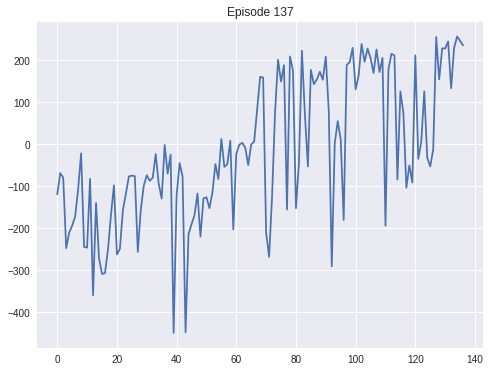

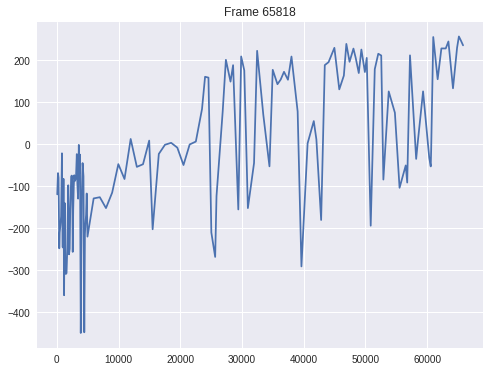

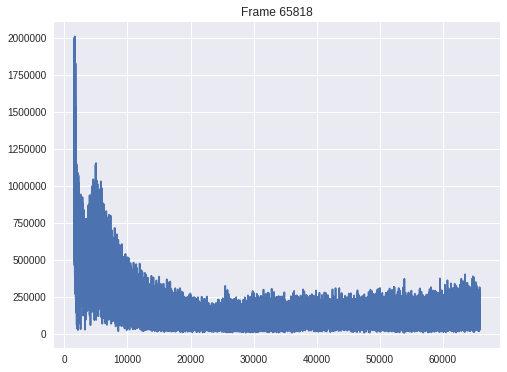

In [0]:
plt.figure(figsize=(8, 6))
plt.title('Episode %s' % len(all_rewards))
plt.plot(all_rewards)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Frame %s' % max(frame_rewards))
plt.plot(frame_rewards, all_rewards)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Frame %s' % max(frame_rewards))
plt.plot(loss_frame, loss_list)
plt.show()

In [0]:
sess.close()